In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import levene
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Loading data

In [2]:
# Import data
path = '/Users/dingxuzhou/Downloads'
hospital_df = pd.read_csv(path + '/joined_data.csv', dtype={'GEOID': str})
hospital_df.loc[:,'GEOID'] = hospital_df['GEOID'].apply(lambda x: x.zfill(5))
hospital_df = hospital_df[(hospital_df['Year'] >= 2011) & (hospital_df['Year'] <= 2020)]
# Modify columns
hospital_df.loc[:, 'Net Household Outflow'] = hospital_df['Outflow_Household'] - hospital_df['Inflow_Household']
hospital_df.loc[:, 'Net Individual Outflow'] = hospital_df['Outflow_Individual'] - hospital_df['Inflow_Individual']
hospital_df.loc[:, 'Net AGI Outflow'] = hospital_df['Outflow_AGI'] - hospital_df['Inflow_AGI']
hospital_df.loc[:, 'Ruca Rural Percentage'] = hospital_df['RucaRural']/(hospital_df['RucaRural'] + hospital_df['RucaSuburban'] + hospital_df['RucaUrban'])
hospital_df = hospital_df.drop(columns=['Outflow_Household', 'Inflow_Household', 'Outflow_Individual',
                                        'Inflow_Individual', 'Outflow_AGI', 'Inflow_AGI',
                                          'RucaRural', 'RucaSuburban', 'RucaUrban'])

# Data Visualization for closure hospital in CDC classification

In [3]:
# Filter out the hospital that has closed
filter_df = hospital_df[hospital_df['HasClosed'] != 0]
filter_df = filter_df.sort_values(by=['HID', 'Year']) 
filter_df = filter_df.drop_duplicates(subset='HID', keep='last')
filter_df.reset_index(drop=True, inplace=True)

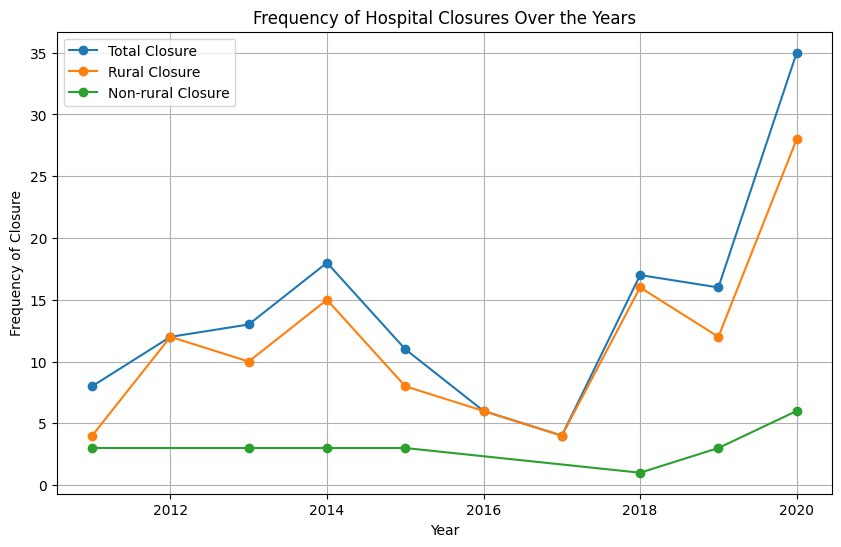

In [5]:
# Plot the frequency of hospital closures over the years
rural_closure = filter_df[filter_df['CdcRurality'] > 3].groupby('Year').size().reset_index(name='Rural Closure')
non_rural_closure = filter_df[filter_df['CdcRurality'] < 4].groupby('Year').size().reset_index(name='Non-rural Closure')
all_closure = filter_df.groupby('Year').size().reset_index(name='Total Closure')

plt.figure(figsize=(10, 6))
plt.plot(all_closure['Year'], all_closure['Total Closure'], marker='o', linestyle='-')
plt.plot(rural_closure['Year'], rural_closure['Rural Closure'], marker='o', linestyle='-')
plt.plot(non_rural_closure['Year'], non_rural_closure['Non-rural Closure'], marker='o', linestyle='-')
plt.title('Frequency of Hospital Closures Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency of Closure')
plt.legend(['Total Closure', 'Rural Closure CDC_index', 'Non-rural Closure CDC_index'])
plt.grid(True)
plt.show()


In [6]:
# plot graphs for rural and non-rural counties by cdc rurality index identification
def plot_graph(df, col_name):
    '''
    This function plots the desired index of rural and non-rural counties over the years.

    Input:
    - df: the dataframe
    - col_name: the column name to be plotted

    Output:
    - A plot of the desired index of rural and non-rural counties over the years.
    '''

    # Create a figure and two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
    rural_df = df[df['CdcRurality'] > 3]
    non_rural_df = df[df['CdcRurality'] < 4]

    # Remove outliers using Z-score method
    z_scores_nonrural = np.abs(stats.zscore(non_rural_df[col_name]))
    filter_non_rural_df = non_rural_df[(z_scores_nonrural < 3)]  # Keep only data points within 3 standard deviations
    z_scores_rural = np.abs(stats.zscore(rural_df[col_name]))
    filter_rural_df = rural_df[(z_scores_rural < 3)]  # Keep only data points within 3 standard deviations

    # Find the median and mean population
    median_nonrural = non_rural_df[col_name].median()
    mean_nonrural = non_rural_df[col_name].mean()
    median_rural = rural_df[col_name].median()
    mean_rural = rural_df[col_name].mean()

    # Plot non-rural population on the first subplot
    ax1.plot(filter_non_rural_df[col_name].values, label='Non-rural', color='blue')
    ax1.axhline(y=median_nonrural, color='red', linestyle='--', label='Median')
    ax1.axhline(y=mean_nonrural, color='green', linestyle='--', label='Mean')
    ax1.set_xlabel('Data Points')
    ax1.set_ylabel(col_name)
    ax1.legend()

    # Plot rural population on the second subplot
    ax2.plot(filter_rural_df[col_name].values, label='Rural', color='red')
    ax2.axhline(y=median_rural, color='blue', linestyle='--', label='Median')
    ax2.axhline(y=mean_rural, color='green', linestyle='--', label='Mean')
    ax2.set_xlabel('Data Points')
    ax2.set_ylabel(col_name)
    ax2.legend()

    plt.tight_layout()
    plt.show()


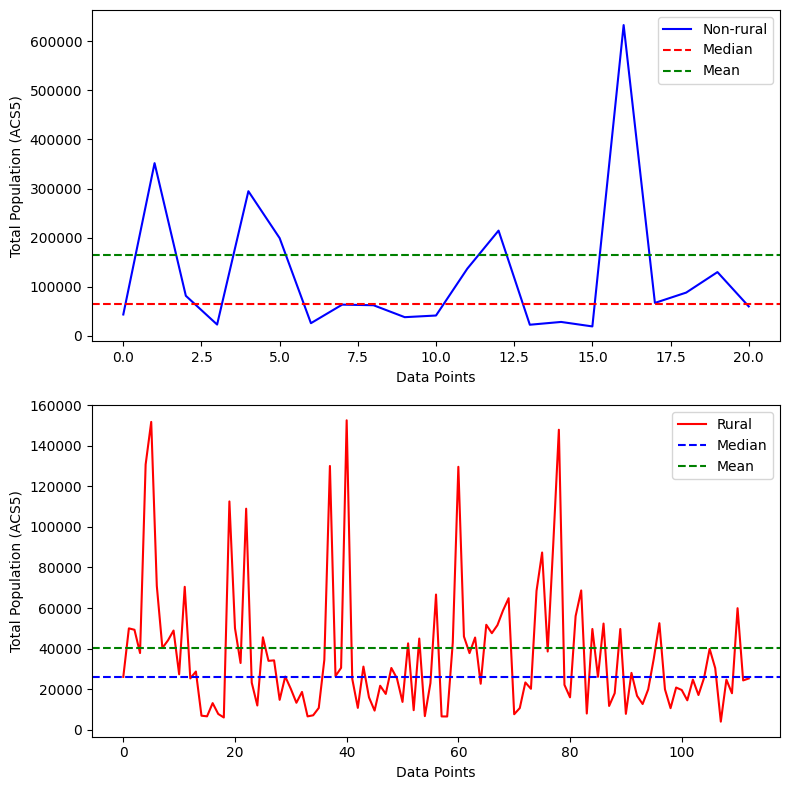

In [ ]:
plot_graph(filter_df, 'Total Population (ACS5)')

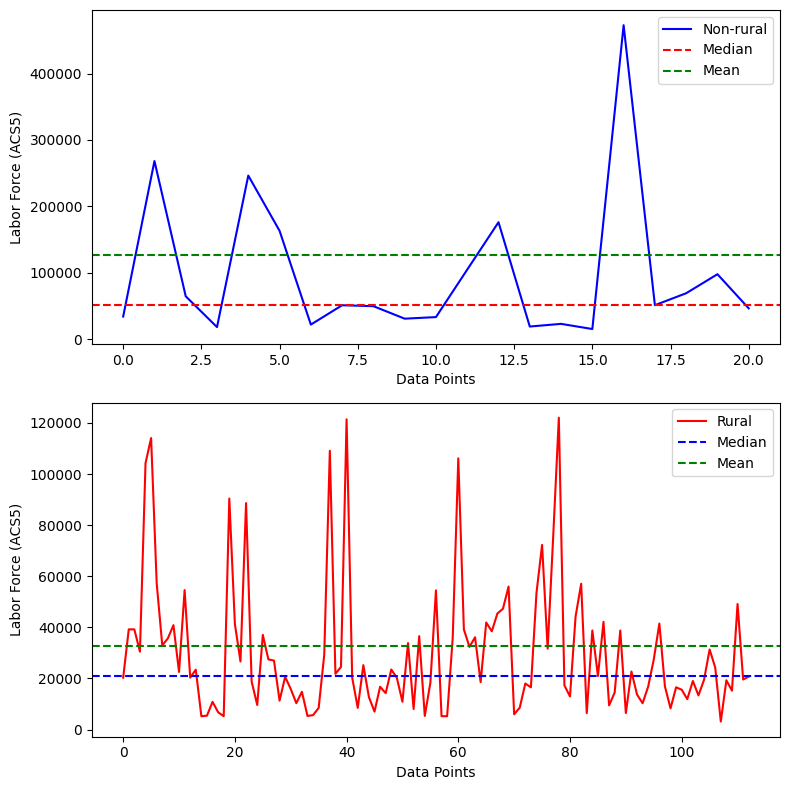

In [ ]:
plot_graph(filter_df, 'Labor Force (ACS5)')

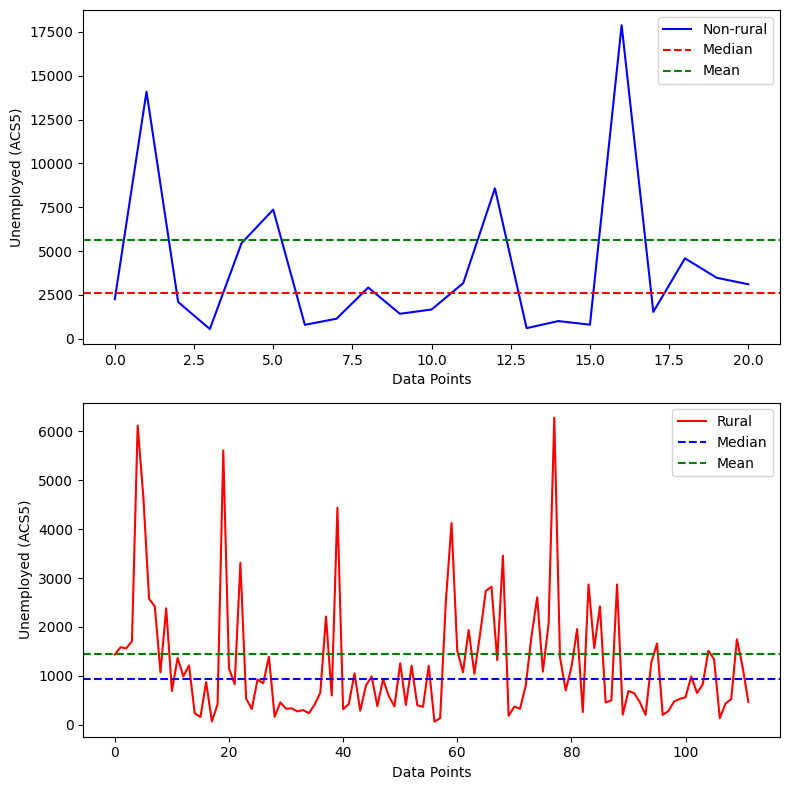

In [ ]:
plot_graph(filter_df, 'Unemployed (ACS5)')

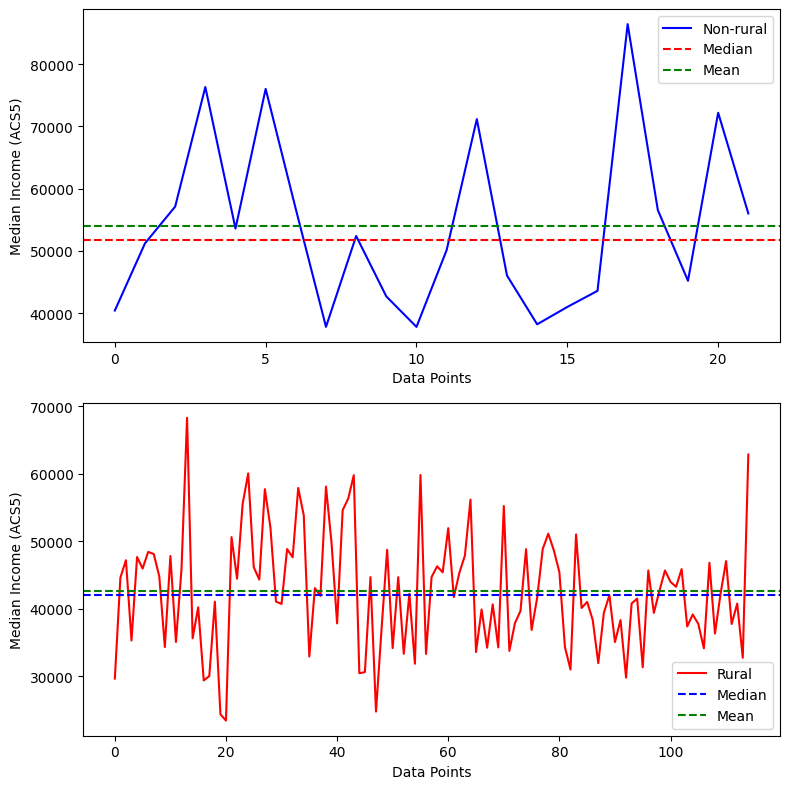

In [ ]:
plot_graph(filter_df, 'Median Income (ACS5)')

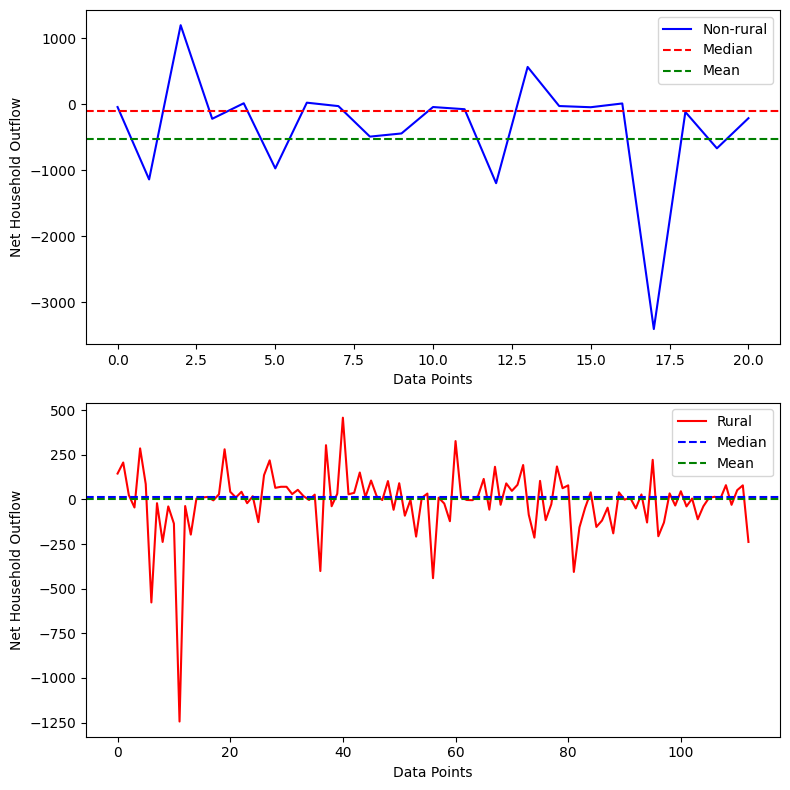

In [ ]:
plot_graph(filter_df, 'Net Household Outflow')

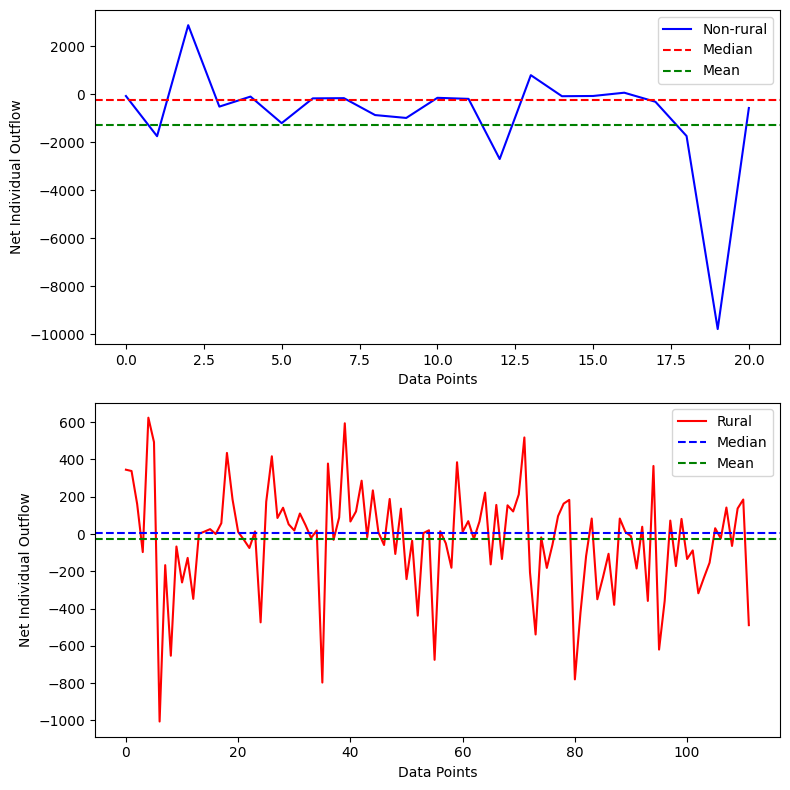

In [ ]:
plot_graph(filter_df, 'Net Individual Outflow')

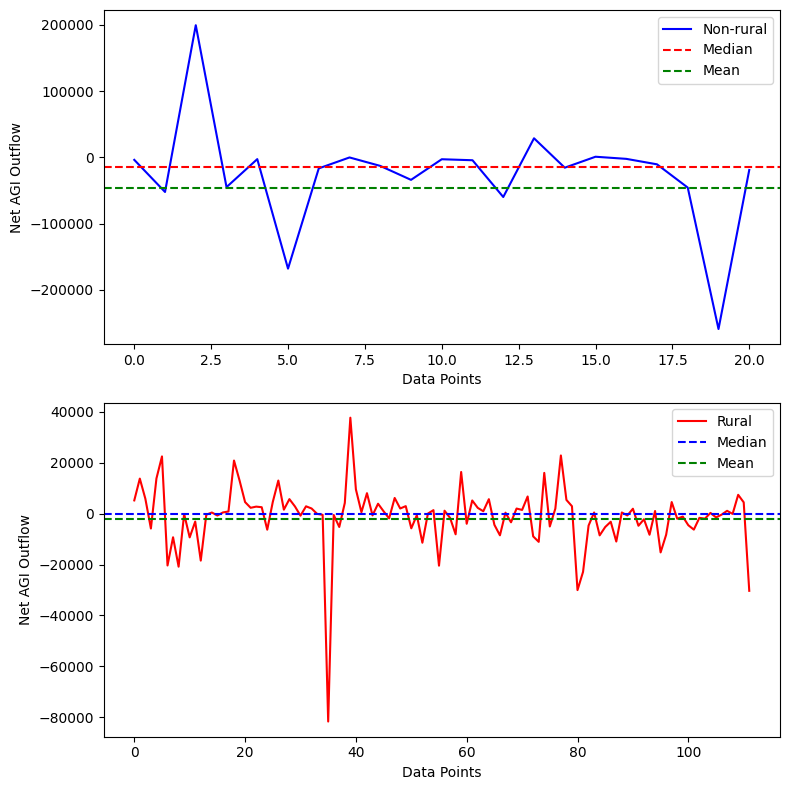

In [ ]:
plot_graph(filter_df, 'Net AGI Outflow')

# Logistic Regression

In [7]:
# Drop columns that are not needed for Regression
Regression_df = hospital_df.copy()
Regression_df.drop(columns=['Name', 'Address', 'City', 'State', 'Zip', 
                  'Total Population (ACS1)', 'Labor Force (ACS1)', 'Unemployed (ACS1)', 
                  'Median Income (ACS1)', 'Labor Force (ACSSE)', 'Unemployed (ACSSE)', 
                  'Median Income (ACSSE)', 'Total Population (ACSSE)','ClosureMonth', 'Converted', 
                  'HospitalType', 'GEOID', 'Medicare Payment', '# of Beds', 'HasEmergencyServices', 
                  'HasBirthingFriendlyDesignation'], inplace=True)

In [9]:
# Process the DataFrame by making variables into absolute differences and percentage changes
grouped = Regression_df.groupby('HID')
filtered_groups = []
modified_df = pd.DataFrame()
percentage_groups = []
percentage_df = pd.DataFrame()

for _, group in grouped:
    if group['HasClosed'].any() != 0:
        closure_year = group.loc[group['HasClosed'] != 0, 'ClosureYear'].values[0]
        rows_for_calculation = group[(group['Year'] == closure_year) | (group['Year'] == closure_year - 1)]
    else:
        latest_year = group['Year'].max()
        rows_for_calculation = group[(group['Year'] == latest_year) | (group['Year'] == latest_year - 1)]
    
    if not rows_for_calculation.empty:
        exclude_columns = ['HID', 'Year', 'HasClosed', 'ClosureYear', 'FarP', 'CdcRurality', 'Ruca Rural Percentage']
        columns_for_calculation = [col for col in rows_for_calculation.columns if col not in exclude_columns]
        differences = rows_for_calculation[columns_for_calculation].diff()
        filled_rows = rows_for_calculation[columns_for_calculation].ffill()
        percentage_changes = filled_rows.pct_change() * 100

        latest_year_data = rows_for_calculation[rows_for_calculation['Year'] == rows_for_calculation['Year'].max()]
        latest_year_data = latest_year_data.drop(columns=columns_for_calculation)

        if len(differences) > 1:
            combined_data = pd.concat([latest_year_data, differences.iloc[[1]]], axis=1)
        else:
            combined_data = pd.concat([latest_year_data, differences], axis=1)
        filtered_groups.append(combined_data)

        combined_data_pct = pd.concat([latest_year_data, percentage_changes], axis=1)
        percentage_groups.append(combined_data_pct)

modified_df = pd.concat(filtered_groups)
percentage_df = pd.concat(percentage_groups)

In [72]:
# Deal with multiple HID errors in original df
def deal_with_HID(df):
    grouped = df.groupby('HID')
    selected_rows = []
    for _, group in grouped:
        # Calculate the count of non-zero values in each row
        non_zero_counts = group.apply(lambda row: (row != 0).sum(), axis=1)
        max_non_zero_index = non_zero_counts.idxmax()
        selected_row = group.loc[max_non_zero_index]
        selected_rows.append(selected_row)

    modified_df = pd.concat(selected_rows, axis=1).T
    return modified_df

modified_df = deal_with_HID(modified_df)
percentage_df = deal_with_HID(percentage_df)

## Logistic Regression of absolute difference

In [73]:
modified_df.fillna(0, inplace=True)
modified_df.drop(columns=['ClosureYear', 'HID', 'Year', 'Net Household Outflow'], inplace=True)
zero_counts = (modified_df == 0).sum(axis=1)
# Filter out rows with more than 12 zeros
final_df = modified_df[zero_counts <= 12]
final_df.reset_index(drop=True, inplace=True)

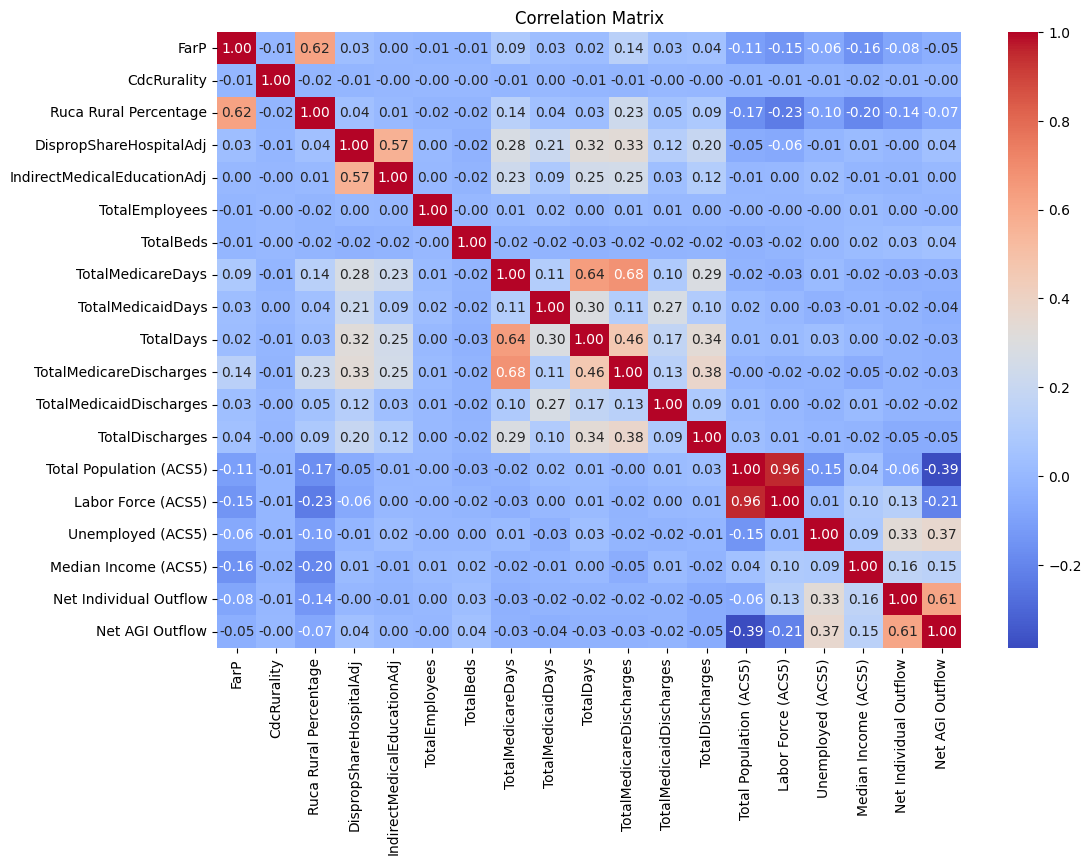

In [76]:
# Check for correlation among independent variables
correlation_matrix = final_df.drop(columns=['HasClosed']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [77]:
# Find variables with high correlation and drop one of them
highly_correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Adjust the threshold as needed
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_vars.add(colname_i)
            highly_correlated_vars.add(colname_j)
final_df_filter = final_df.drop(columns=highly_correlated_vars)

# Check new correlation matrix
correlation_matrix_filter = final_df_filter.drop(columns=['HasClosed']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filter, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# logit model
X = final_df_filter.drop(columns=['HasClosed'])
X = sm.add_constant(X)
y = final_df_filter['HasClosed']
logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary()

# Logistic Regression of percentage change

In [ ]:
percentage_df.fillna(0, inplace=True)
percentage_df.drop(columns=['ClosureYear', 'HID', 'Year', 'Net Household Outflow'], inplace=True)
zero_counts = (modified_df == 0).sum(axis=1)
# Filter out rows with more than 12 zeros
final_percentage_df = percentage_df[zero_counts <= 12]
final_percentage_df.reset_index(drop=True, inplace=True)

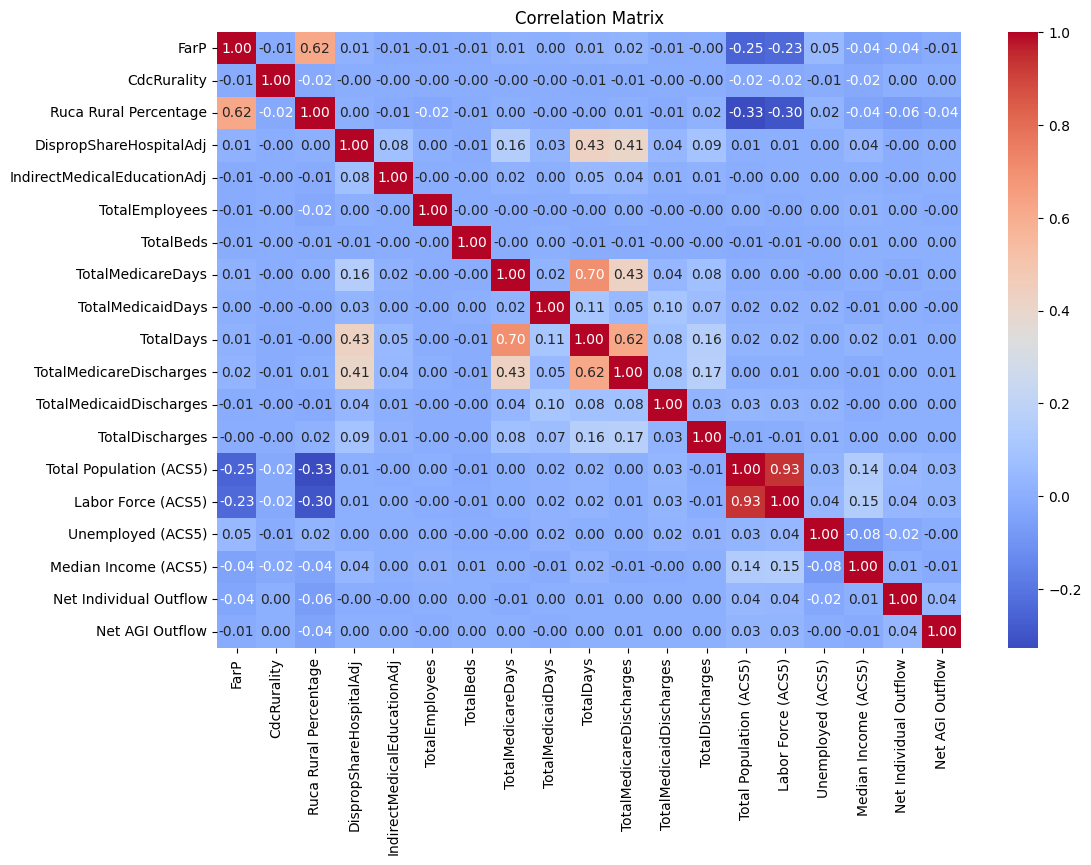

In [16]:
# Check for correlation among independent variables
correlation_matrix = final_percentage_df.drop(columns=['HasClosed']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

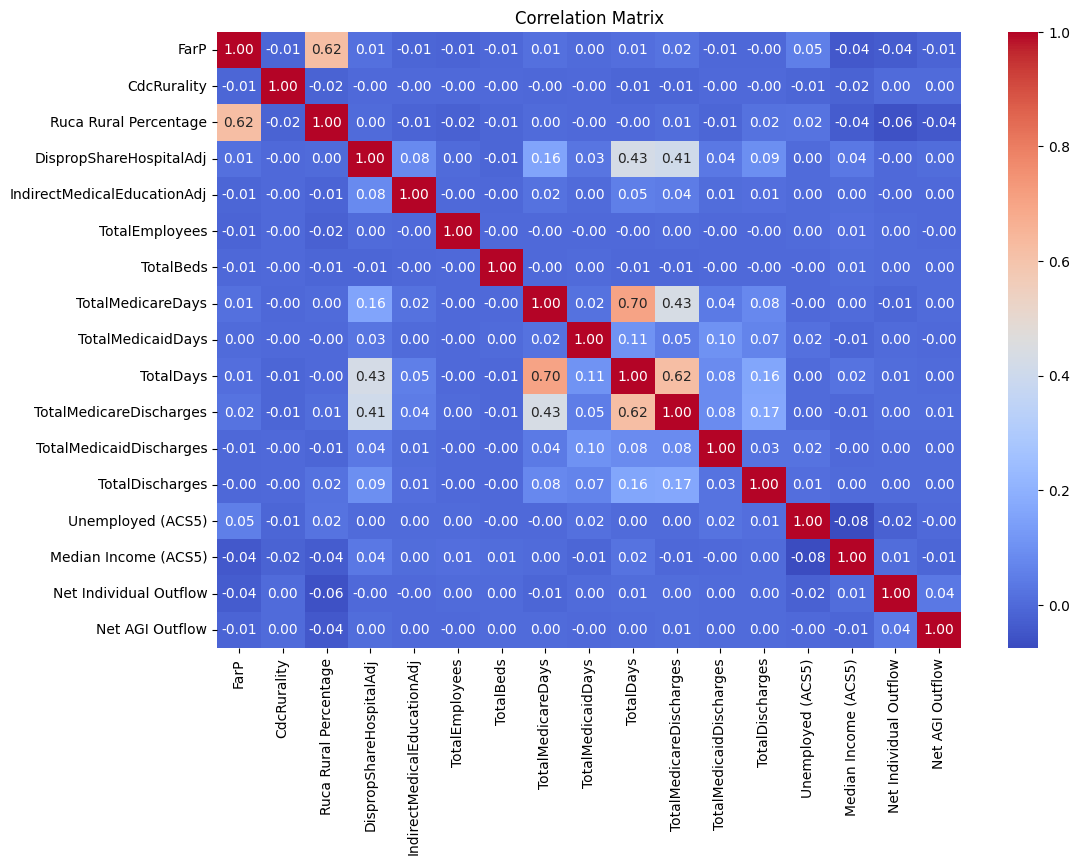

In [18]:
# Find variables with high correlation and drop one of them
highly_correlated_vars = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:  # Adjust the threshold as needed
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_vars.add(colname_i)
            highly_correlated_vars.add(colname_j)
final_percentage_df_filter = final_percentage_df.drop(columns=highly_correlated_vars)

# Check new correlation matrix
correlation_matrix_filter = final_percentage_df_filter.drop(columns=['HasClosed']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_filter, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [25]:
# Deal with the object type columns
object_columns = final_percentage_df_filter.select_dtypes(include=['object']).columns
for column in object_columns:
    final_percentage_df_filter[column] = pd.to_numeric(final_percentage_df_filter[column], errors='coerce')
final_percentage_df_filter.dropna(inplace=True)

In [30]:
# logit model
X = final_percentage_df_filter.drop(columns=['HasClosed'])
X.replace([np.nan, np.inf, -np.inf], 0, inplace=True)
X = sm.add_constant(X)
y = final_percentage_df_filter['HasClosed']
logit_model = sm.Logit(y, X)
result = logit_model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.067305
         Iterations 15


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              HasClosed   No. Observations:                 6751
Model:                          Logit   Df Residuals:                     6733
Method:                           MLE   Df Model:                           17
Date:                Tue, 27 Feb 2024   Pseudo R-squ.:                  0.1794
Time:                        00:51:44   Log-Likelihood:                -454.38
converged:                       True   LL-Null:                       -553.75
Covariance Type:            nonrobust   LLR p-value:                 5.143e-33
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -4.9695      0.192    -25.845      0.000      -5.346      -4.593
FarP                           -0.0135      0.004     -3.641      0.000      -0.021      -0.006
CdcRurality                 -1.453e-05      0.000     -0.065      0.948      -0.000       0.000
Ruca Rural Percentage           2.2666      0.270      8.381      0.000       1.737       2.797
DispropShareHospitalAdj        -0.0048      0.004     -1.354      0.176      -0.012       0.002
IndirectMedicalEducationAdj  5.478e-05      0.001      0.037      0.971      -0.003       0.003
TotalEmployees                 -0.0011      0.003     -0.332      0.740      -0.007       0.005
TotalBeds                   -6.005e-05      0.001     -0.059      0.953      -0.002       0.002
TotalMedicareDays              -0.0048      0.005     -0.918      0.359      -0.015       0.005
TotalMedicaidDays               0.0002   3.59e-05      4.376      0.000    8.68e-05       0.000
TotalDays                      -0.0270      0.004     -6.694      0.000      -0.035      -0.019
TotalMedicareDischarges         0.0065      0.005      1.366      0.172      -0.003       0.016
TotalMedicaidDischarges     -6.233e-05      0.000     -0.235      0.814      -0.001       0.000
TotalDischarges                -0.0001      0.000     -0.345      0.730      -0.001       0.001
Unemployed (ACS5)              -0.0070      0.005     -1.355      0.175      -0.017       0.003
Median Income (ACS5)           -0.1139      0.023     -4.871      0.000      -0.160      -0.068
Net Individual Outflow          0.0002      0.000      1.205      0.228      -0.000       0.001
Net AGI Outflow             -8.072e-06   4.94e-05     -0.163      0.870      -0.000    8.88e-05
===============================================================================================
"""

# Classifiers of Naive Bayesian and Random Forest

In [92]:
X = final_percentage_df_filter.drop(columns=['HasClosed'])
y = final_percentage_df_filter['HasClosed']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train_resampled, y_train_resampled)
nb_predictions = nb_classifier.predict(X_test)

# Evaluate the performance
print("Naive Bayes Classifier with SMOTE:")
print("Accuracy:", accuracy_score(y_test, nb_predictions))
print("Classification Report:")
print(classification_report(y_test, nb_predictions))

Naive Bayes Classifier with SMOTE:
Accuracy: 0.4167289021657954
Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.41      0.58      1327
         1.0       0.02      1.00      0.03        12

    accuracy                           0.42      1339
   macro avg       0.51      0.71      0.31      1339
weighted avg       0.99      0.42      0.58      1339



In [99]:
# Compute class weights based on the imbalance in the training data
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1, class_weight={0: class_weights[0], 1: class_weights[1]}, random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_classifier.predict(X_test)

# Evaluate the performance
print("Random Forest Classifier with Class Weighting:")
print("Classification Report:")
print(classification_report(y_test, rf_predictions))


Random Forest Classifier with Class Weighting:
Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1508
         1.0       0.00      0.00      0.00        13

    accuracy                           0.99      1521
   macro avg       0.50      0.50      0.50      1521
weighted avg       0.98      0.99      0.99      1521



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.